# **HALLUCINATED DATASET CREATION**

**DESCRIPTION**

1. Load a QA dataset, split each answer into sentence-level facts, and randomly pick a subset to corrupt.
2. Call GPT-4o with a structured prompt to rewrite those facts into plausible hallucinations while preserving context formatting.
3. Reassemble answers, label each fact as “correct” or “hallucinated,” and save the augmented dataset as `hallucinated_answers.json`.
4. Make sure you run this notebook on Colab


**REQUIREMENTS**

In [ ]:
!pip install -q \
  openai==0.28.0 \
  tqdm>=4.66,<5.0 \
  python-dotenv>=1.0,<2.0

**IMPORTS**

In [2]:
# @title

from pathlib import Path
import textwrap
import os
import json, random, re
from typing import List, Dict
from tqdm import tqdm
import json
from pathlib import Path
from tqdm import tqdm
from openai import OpenAI

OPENAI_API_KEY="your key"
client = OpenAI(api_key=OPENAI_API_KEY)

INPUT_FILE  = Path("uptrain_results.json")
OUTPUT_FILE = Path("hallucinated_answers.json")

The uptrain results.json file is same file we make which we run our dataset gathered from dataset_generation.ipynb file on uptrain factual accuracy evaluator, use the wrapper, and store results like this or for refernce in evalutors notebook, code is avaialble. It will look like this
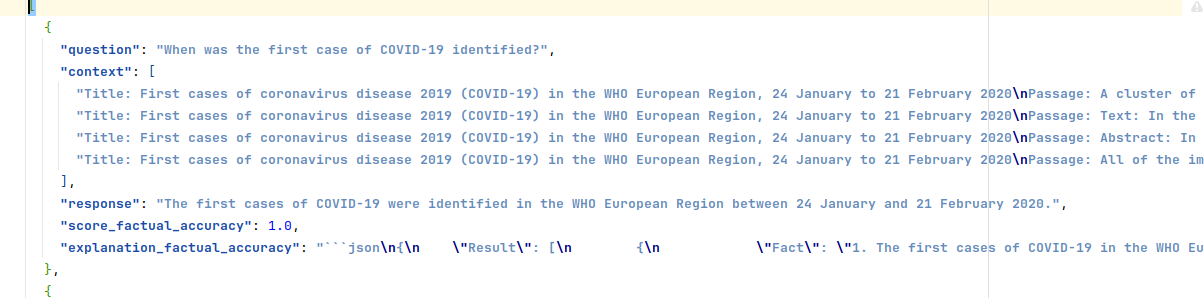

**PROMPTS**

In [3]:
HALLUCINATION_PROMPT_TEMPLATE = textwrap.dedent("""
    You are a *hallucination generator*.
    Starting from factually correct statements, produce *plausible but incorrect* versions.

    Ways you may hallucinate:
    1. **False negative** – context has the answer but you say «I don’t know».
    2. **Context override** – trust world knowledge over supplied context.
    3. **Fabrication** – invent a detail not found in any context chunk.
    4. **Mis-reading** – misinterpret context to answer wrongly.
    5. **Over-generalisation** – vague answer unsupported by context.
    6. **Contradiction** – directly oppose retrieved content.
    7. **Merge conflicts** – blend contradictory chunks into one answer.
    8. **Wrong span** – quote the wrong piece due to ambiguity.

    ---
    ### Context:
    {context_text}

    ### Facts to Hallucinate:
    {fact_str}

    ### Output JSON
    {{ "hallucinated_fact_1": "...", "hallucinated_fact_2": "..." }}
""").strip()


**GENERAL FUNCTIONS**

In [4]:

def split_into_facts(answer: str) -> List[str]:
    return [s.strip() for s in answer.split('.') if s.strip()]

def choose_random_facts(facts: List[str]) -> List[str]:
    n = len(facts)
    if n <= 1:
        return facts
    sample_map = {range(2, 4): 1, range(4, 6): 2}
    for rng, k in sample_map.items():
        if n in rng:
            return random.sample(facts, k)
    return random.sample(facts, 3)


def _extract_json(raw: str) -> Dict[str, str]:
    try:
        match = re.search(r"\{.*\}", raw, flags=re.DOTALL)
        return json.loads(match.group()) if match else {}
    except Exception as exc:
        print("JSON parse failed:", exc)
        return {}

def hallucinate(facts: List[str], context: List[str]) -> Dict[str, str]:
    prompt = HALLUCINATION_PROMPT_TEMPLATE.format(
        context_text="\n".join(context),
        fact_str="\n".join(f"- {f}" for f in facts)
    )
    resp = client.chat.completions.create(
    model="gpt-4o",
    temperature=0.7,
    messages=[
        {"role": "system", "content": "You are a hallucination generator."},
        {"role": "user", "content": prompt},
    ],
    )
    return _extract_json(resp.choices[0].message.content)


**RUN**

In [ ]:
def main() -> None:
    data = json.loads(INPUT_FILE.read_text())
    results = []

    for item in tqdm(data, desc="Generating hallucinations"):
        facts           = split_into_facts(item["response"])
        subset          = choose_random_facts(facts)
        hallucinations  = hallucinate(subset, item["context"])

        # map originals → hallucinated
        mapping = {
            original: hallucinations.get(f"hallucinated_fact_{i+1}", original)
            for i, original in enumerate(subset)
        }

        # build labelled answer
        rebuilt_parts, labels = [], []
        for fact in facts:
            if fact in mapping:
                rebuilt_parts.append(mapping[fact])
                labels.append({"fact": mapping[fact], "label": "hallucinated"})
            else:
                rebuilt_parts.append(fact)
                labels.append({"fact": fact, "label": "correct"})

        results.append(
            dict(
                question           = item["question"],
                original_answer    = item["response"],
                hallucinated_answer= ". ".join(rebuilt_parts) + ".",
                context            = item["context"],
                labeled_facts      = labels,
            )
        )

    OUTPUT_FILE.write_text(json.dumps(results, indent=2))
    print(f"✅ Saved {len(results)} items → {OUTPUT_FILE}")
if __name__ == "__main__":
    main()